# Dynamic LDA

In [2]:
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)

import os
import sys
import gensim
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from Preprocess import preprocess
from Plot import plot_df

# Run the preprocessing 
df= preprocess('Data/articles.json')

# Create a dictionary from the tokenized documents
dictionary = Dictionary(df['content'])

# Filter out extreme words based on their frequency
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the dictionary to a bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in df['content']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/faculty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/faculty/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/faculty/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Hyperparameter tuning

In [13]:
# Set up the parameter grid for tuning
param_grid = {
    'num_topics': [10, 20, 30],  # Test different values for the number of topics
    'alpha': [0.01, 0.1, 1.0],   # Test different values for alpha
    'eta': [0.01, 0.1, 1.0]       # Test different values for beta (eta in Gensim)
}

# Perform grid search
best_coherence = -1
best_model = None

for num_topics in param_grid['num_topics']:
    for alpha in param_grid['alpha']:
        for eta in param_grid['eta']:
            # Train the LDA model
            model = LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=num_topics,
                alpha=alpha,
                eta=eta,
                random_state=42
            )
            
            # Compute coherence score
            coherence_model = gensim.models.CoherenceModel(model=model, texts= df['content'], dictionary=dictionary, coherence='c_v')
            coherence = coherence_model.get_coherence()
            
            # Check if this model has the highest coherence so far
            if coherence > best_coherence:
                best_coherence = coherence
                best_model = model

# Get the best parameters
best_num_topics = best_model.num_topics
best_alpha = best_model.alpha
best_eta = best_model.eta


print("Best number of topics:", best_num_topics)
print("Best alpha value:", best_alpha[0])
print("Best eta value:", best_eta[0])

Best number of topics: 10
Best alpha value: 0.01
Best eta value: 1.0


# Train the model

In [3]:
# Set the best parameters
num_topics = 10
best_alpha = 0.01
best_eta =  1.0

# Train the LDA model with the best hyperparameters
model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    alpha=num_topics,
    eta=best_eta,
    random_state=42
)

topics = model.show_topics(num_topics=num_topics)

topic_words = []
for topic in topics:
    topic_words.append([word for word, _ in model.show_topic(topic[0])])

# Print the topic words
for i, words in enumerate(topic_words):
    print(f"Topic {i+1}: {', '.join(words)}")

Topic 1: flood, defenc, england, project, peopl, develop, natur, manag, need, fund
Topic 2: £, develop, project, busi, peopl, intern, climat, countri, food, need
Topic 3: flood, develop, protect, busi, commun, project, fund, peopl, manag, water
Topic 4: flood, busi, fund, commun, protect, £, project, peopl, minist, plan
Topic 5: project, flood, £, develop, busi, across, fund, protect, scheme, million
Topic 6: flood, project, water, develop, protect, busi, manag, plan, peopl, england
Topic 7: £, develop, busi, fund, peopl, flood, fish, research, commun, innov
Topic 8: develop, busi, project, protect, flood, £, across, peopl, fund, import
Topic 9: busi, develop, peopl, project, fund, flood, £, climat, protect, need
Topic 10: flood, £, england, fund, water, develop, project, peopl, busi, natur


/tmp/ipykernel_1054/2557748605.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topic_means = df_copy.groupby('year-month').mean()


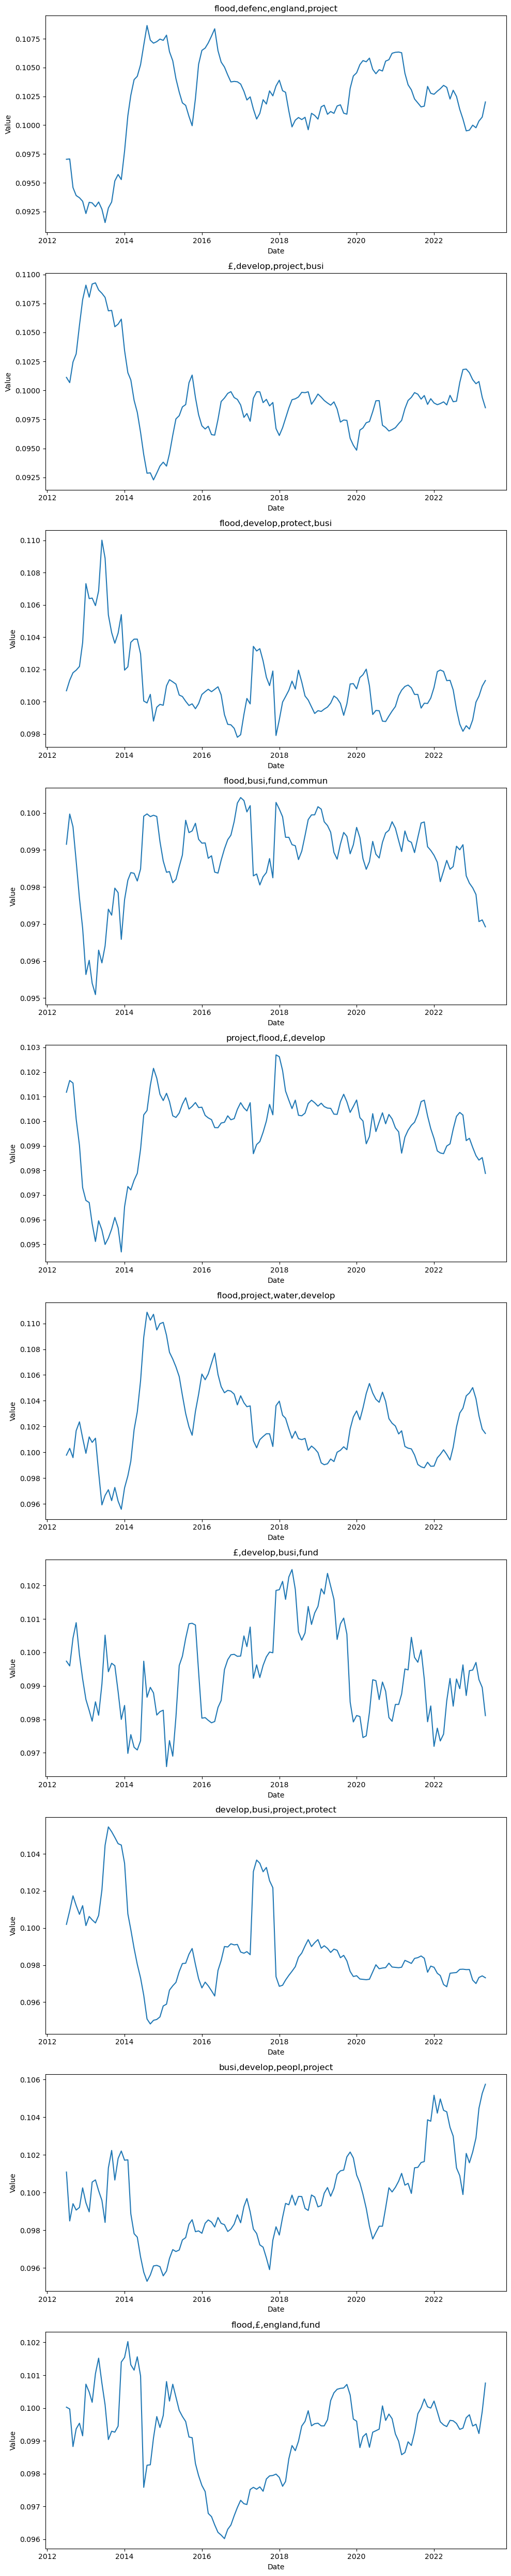

In [4]:
df_copy = df.copy()

# Calculate the topic proportions for each document
topic_proportions = model.get_document_topics(corpus, minimum_probability=0.0)

# Add the topic proportions to the DataFrame
for i, topic in enumerate(topic_words):
    topic_name = str(','.join(topic[:4]))
    df_copy[topic_name] = [doc_topic[i][1] for doc_topic in topic_proportions]
    
topic_means = df_copy.groupby('year-month').mean()

plot_df(topic_means)

# Coherence

In [5]:
from Plot import print_coherence
dic = dictionary
print_coherence(dic, topic_words,df['content'])

Topic: flood,defenc,england,project,peopl,develop,na	Coherence: 0.53
Topic: £,develop,project,busi,peopl,intern,climat,co	Coherence: 0.51
Topic: flood,develop,protect,busi,commun,project,fun	Coherence: 0.57
Topic: flood,busi,fund,commun,protect,£,project,peop	Coherence: 0.55
Topic: project,flood,£,develop,busi,across,fund,prot	Coherence: 0.62
Topic: flood,project,water,develop,protect,busi,mana	Coherence: 0.56
Topic: £,develop,busi,fund,peopl,flood,fish,research	Coherence: 0.49
Topic: develop,busi,project,protect,flood,£,across,p	Coherence: 0.54
Topic: busi,develop,peopl,project,fund,flood,£,clima	Coherence: 0.55
Topic: flood,£,england,fund,water,develop,project,pe	Coherence: 0.55
